<a href="https://colab.research.google.com/github/fookseng/Pytorch-YOLOv5-object-detection/blob/main/pytorch_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1:**
## Clone repository and install dependencies.

In [5]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 6303, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 6303 (delta 8), reused 0 (delta 0), pack-reused 6281
Receiving objects: 100% (6303/6303), 8.52 MiB | 33.16 MiB/s, done.
Resolving deltas: 100% (4313/4313), done.


In [6]:
#installing for google colab GPU use
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html


In [7]:
%cd /content/yolov5

/content/yolov5


In [8]:
import torch
from IPython.display import Image  # for displaying images
from utils.google_utils import gdrive_download  # for downloading models/datasets

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

KeyboardInterrupt: ignored

# **Part 2:**
## Get your images and annotations ready!
*An example for the images and annotations are provided in Github.* 

In [4]:
!curl -L "https://app.roboflow.com/{key}" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1719      0 --:--:-- --:--:-- --:--:--  1719
100 7599k  100 7599k    0     0  7189k      0  0:00:01  0:00:01 --:--:-- 22.4M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: train/
   creating: train/images/
 extracting: train/images/0_jpg.rf.fbd3c34269f7282502ee9e0312d5d989.jpg  
 extracting: train/images/131_jpg.rf.b17c07f3e3cdc678ec694e2c431ef984.jpg  
 extracting: train/images/172_jpg.rf.c8e72ffbd7c7ea49836b696dfaf9d8ac.jpg  
 extracting: train/images/199_jpg.rf.82b7c8ad43b3e844f71bbcd15c25faa3.jpg  
 extracting: train/images/202_jpg.rf.0ed077019e136332f1e021bc9420f9ea.jpg  
 extracting: train/images/47_jpg.rf.ae853cfc92aedc9e1787a38be98eeeae.jpg  
 extracting: train/images/93_jpg.rf.50b7b7fb6f9502444e064f6927b816b7.jpg  
 extractin

In [5]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['stone']

In [6]:
# define number of classes based on YAML
# data.yaml contains the information about number of classes and their labels required for this project
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
# Below we are changing the data configuration for right path to the dataset
%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./valid/images

nc: 1
names: ['stone']

In [9]:
%cat data.yaml


train: ./train/images
val: ./valid/images

nc: 1
names: ['stone']

In [10]:
with open(r'data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    labels_list = yaml.load(file, Loader=yaml.FullLoader)

    label_names = labels_list['names']
print("Number of Classes are {}, whose labels are {} for this Object Detection project".format(num_classes,label_names))

Number of Classes are 1, whose labels are ['stone'] for this Object Detection project


# **Part 3:**
## Model configurations.
*You may try other model to obtain a better result.*

In [11]:
#this is the model configuration we will use for our tutorial
# yolov5l.yaml contains the configuration of neural network required for training.
%cat /content/yolov5/models/yolov5l.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3,

In [12]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [13]:
# Check that we have successfully configure the model.
%cat /content/yolov5/models/custom_yolov5l.yaml


# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3,

# **Part 4:**
## Start our training.

In [14]:
import os
# Change our directory to /yolov5, since train.py file is under here.
os.chdir('/content/yolov5')

### **Some arguements you may use.**
*   img 640 - resize the images to 640x640 pixels
*   batch 4 - 4 images per batch
*   epochs 30 - train for 30 epochs
*   data ./data/clothing.yaml - path to dataset config
*   cfg ./models/yolov5x.yaml - model config
*   weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
*   name yolov5x_clothing - name of our model
*   cache - cache dataset images for faster training

In [ ]:
# Weights & Biases  (optional)
# %pip install -q wandb
# import wandb
# wandb.login()

In [1]:
# train yolov5l on custom dataset object detection data for 600 epochs [aroung 1000 epochs for better training and result]
# NOTE: Kindly be aware of your image size.
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5l.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 540 --batch 16 --epochs 600 --data './data.yaml' --weights '' --cfg ./models/custom_yolov5l.yaml --name "yolov5_stone" --nosave

/content/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-99-g3f74cd9 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='./models/custom_yolov5l.yaml', data='./data.yaml', device='', entity=None, epochs=600, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[540, 540], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5_stone', noautoanchor=False, nosave=True, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5_stone2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-18 07:19:59.283568: I tensorflow/stream_executor/platform/def

# **Part 5:**
## We have done training, start Tensorboard!

In [3]:
# Start tensorboard
# Launch after you have started training to all the graphs needed for inspection
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 158), started 1:28:59 ago. (Use '!kill 158' to kill it.)

<IPython.core.display.Javascript object>

In [2]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5_stone2/test_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


NameError: ignored

In [3]:
# print out an augmented training example
# Below is the augmented training data.
# NOTE: The dataset already contains the augmented data with annotations, so that you dont have to do it.
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5_stone2/train_batch0.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


NameError: ignored

# **Part 6:**
## Inference, detect our object.

In [ ]:
# use the best weights!
# Final weights will be by-default stored at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5_stone6/weights/last.pt --img 540 --conf 0.6 --source ./valid/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=540, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='./valid/images', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5_stone6/weights/last.pt'])
YOLOv5 🚀 v5.0-81-gabfcf9e torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 392 layers, 46600566 parameters, 0 gradients, 114.1 GFLOPS
image 1/25 /content/yolov5/valid/images/65_jpg.rf.81c367849756204e1dc64daa55cf0d42.jpg: 416x544 2 stones, Done. (0.025s)
image 2/25 /content/yolov5/valid/images/91_jpg.rf.caea3d416fa8a44cdd330a9825019dfd.jpg: 416x544 3 stones, Done. (0.024s)
image 3/25 /content/yolov5/valid/images/98_jpg.rf.b34152e29ae1327123c7a14b0d6fd6a3.jpg: 416x544 Done. (0.023s)
image 4/25 /content/yolov5/valid/images/ip_110_jpg.rf.

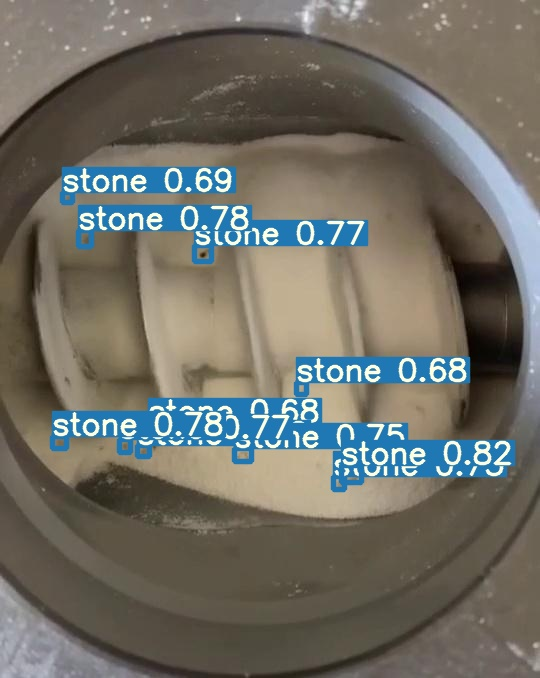

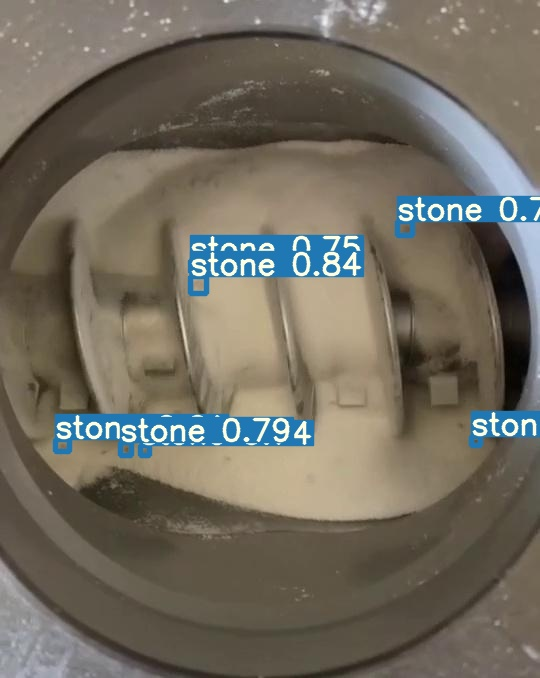

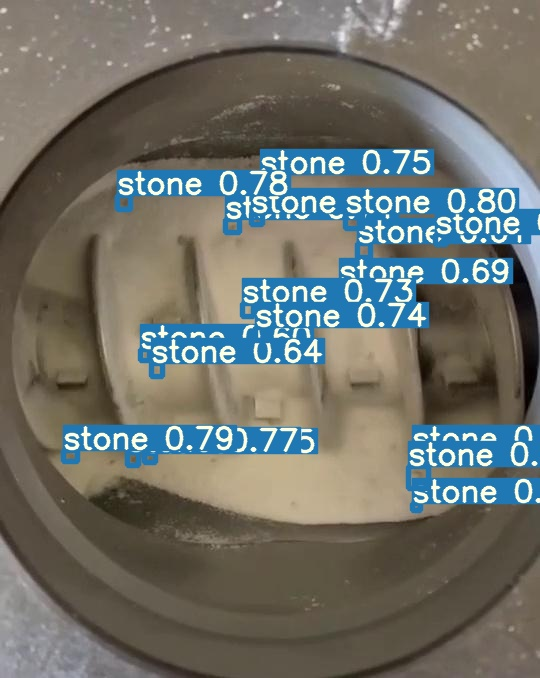

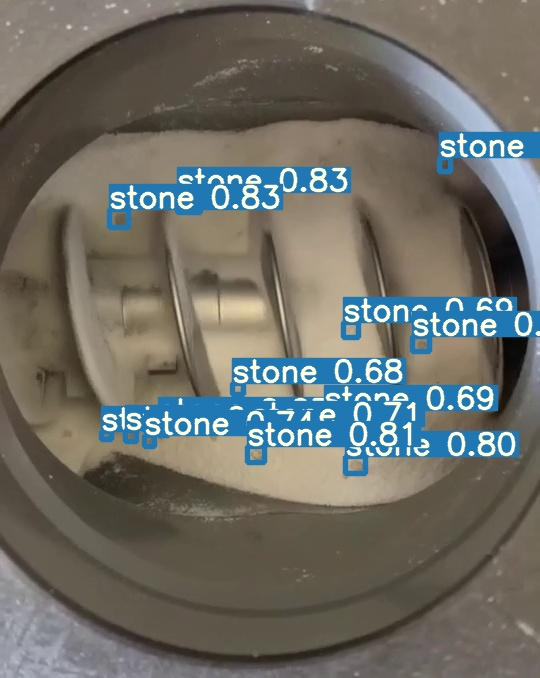

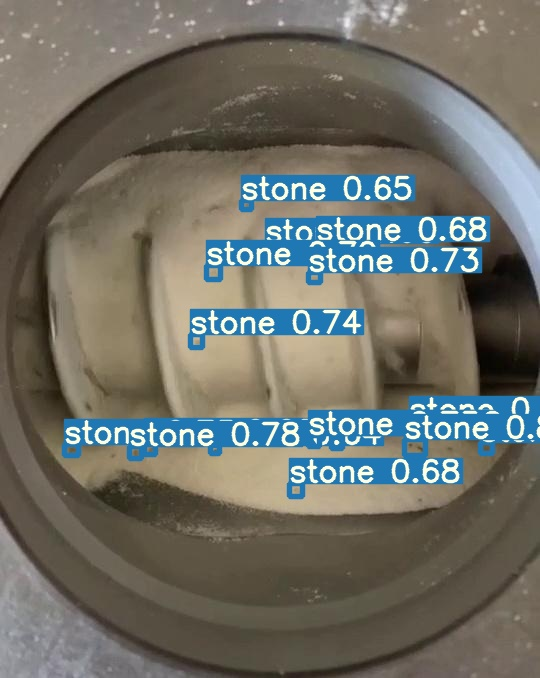

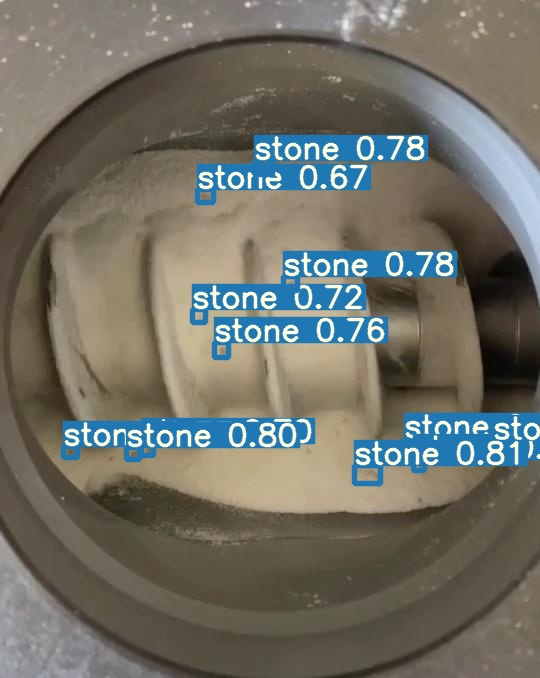

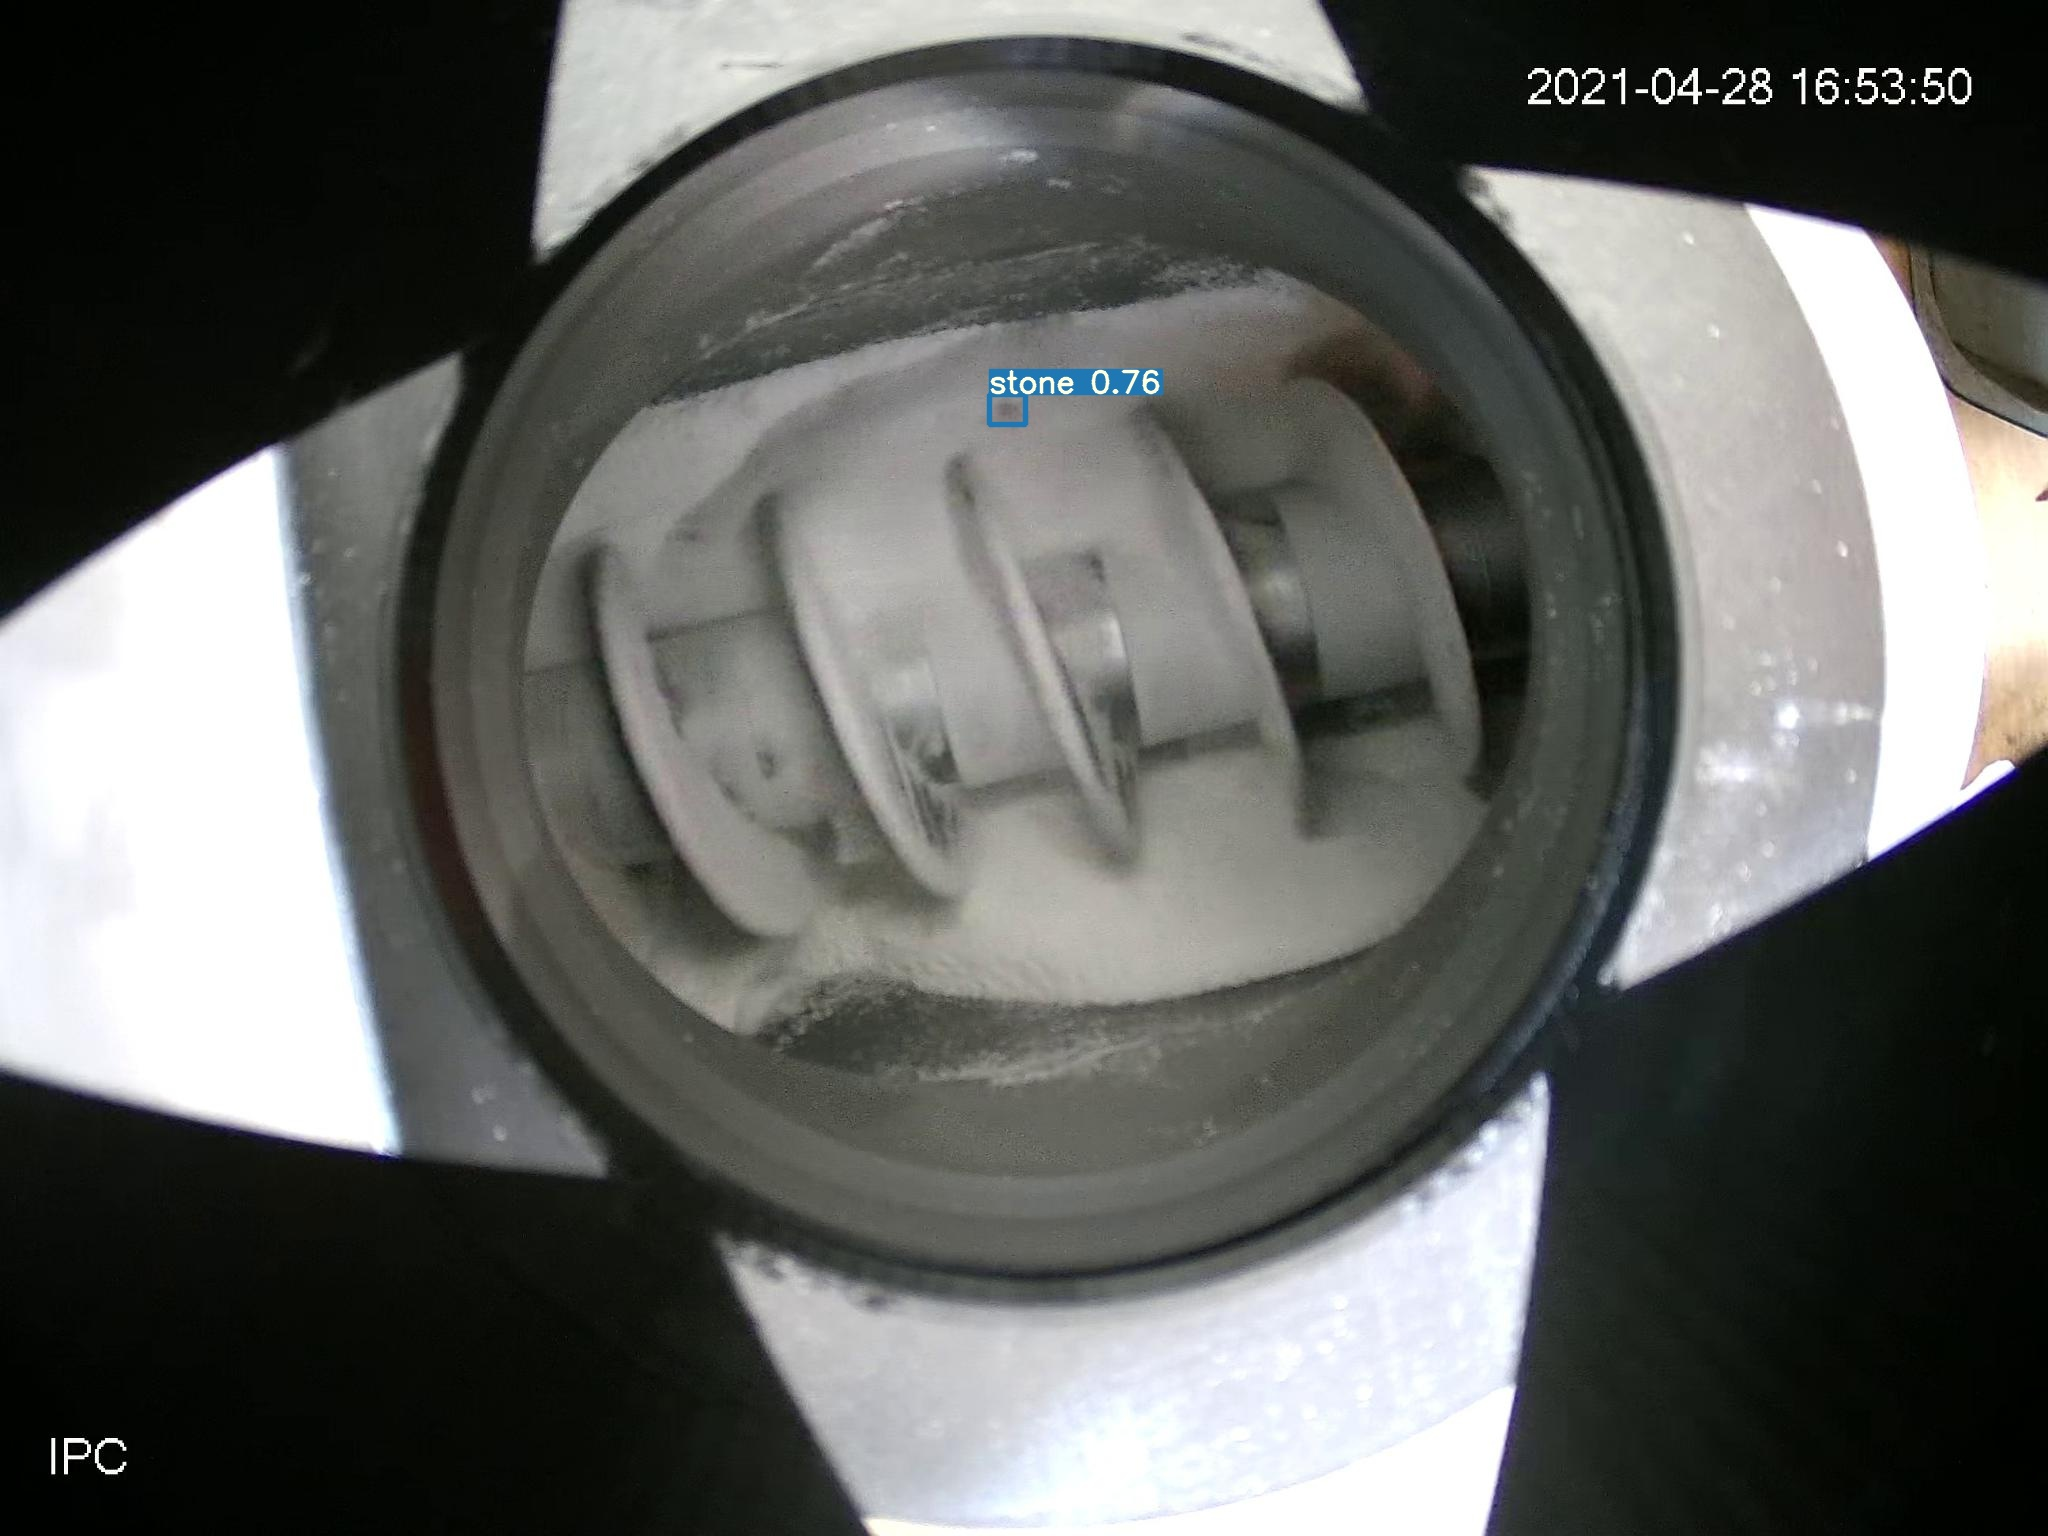

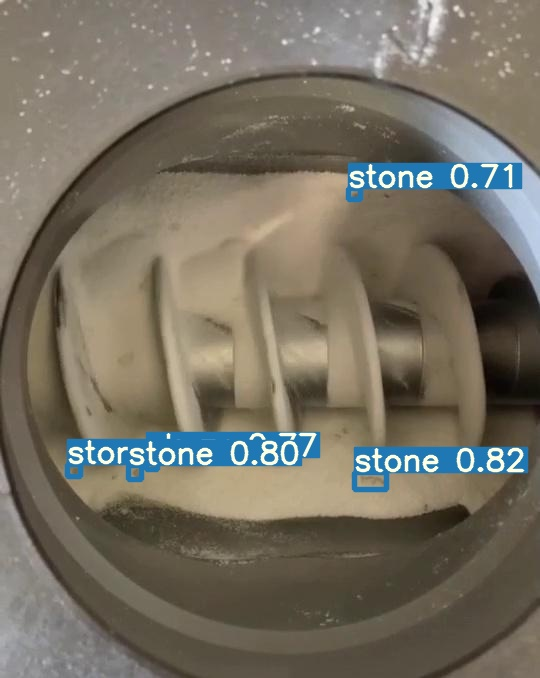

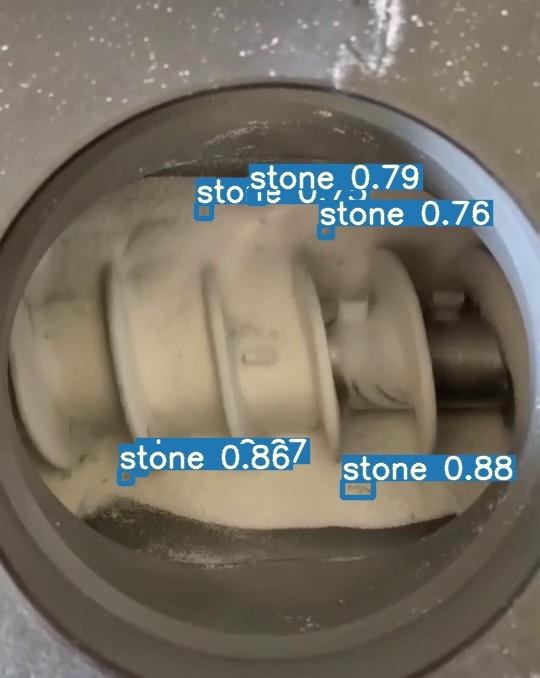

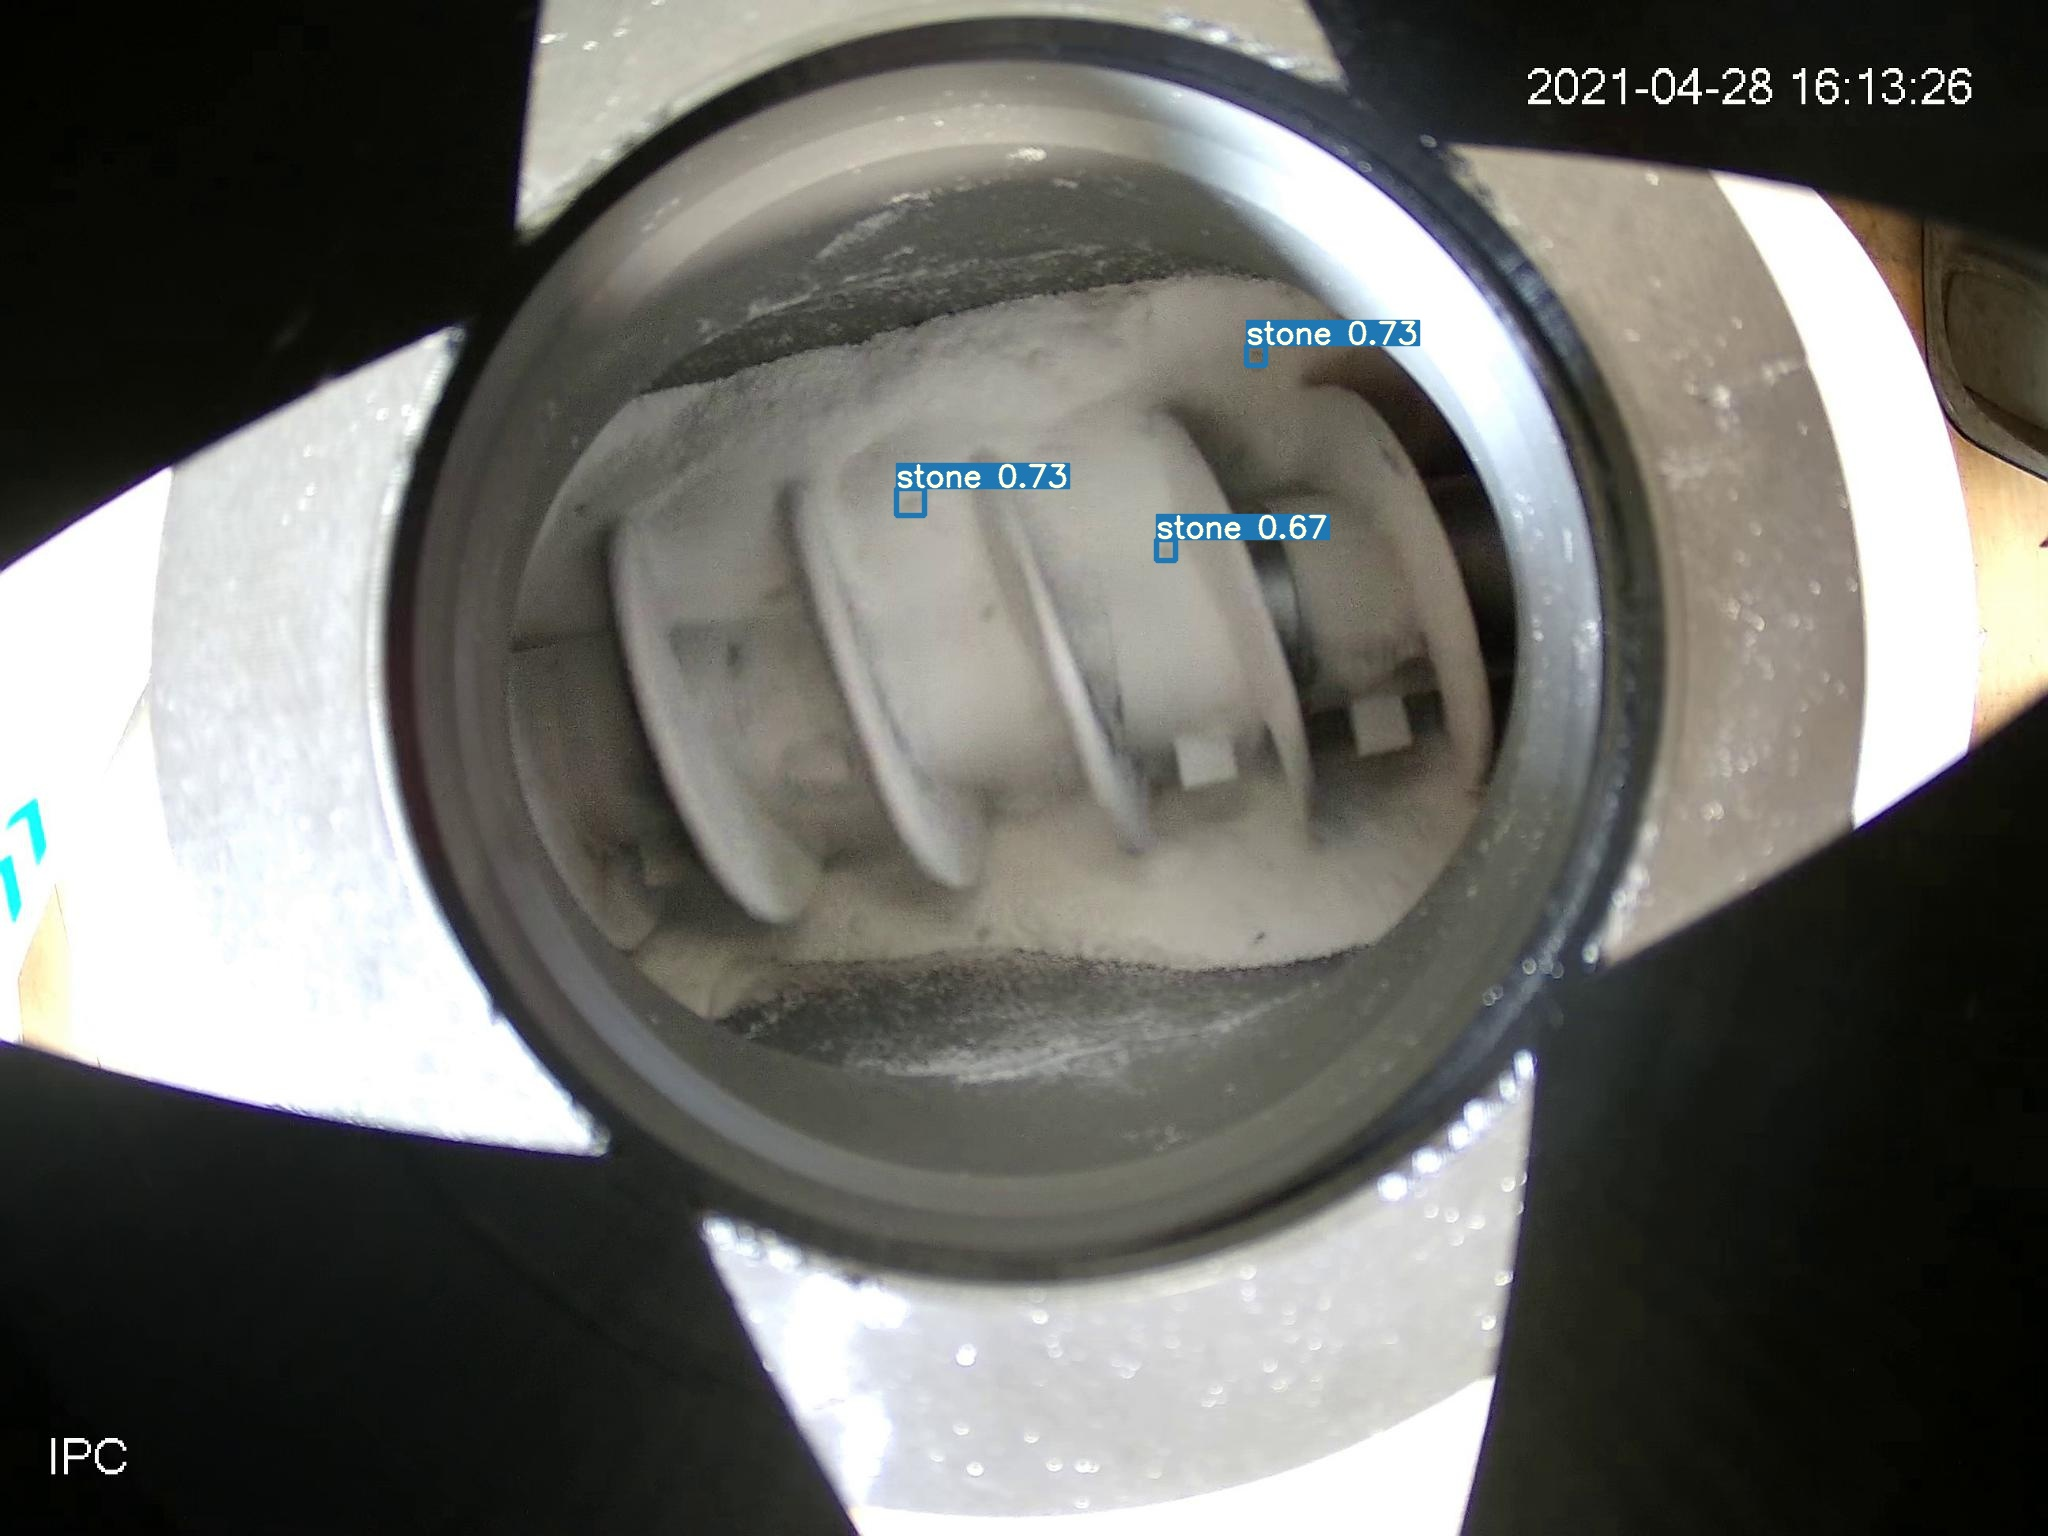

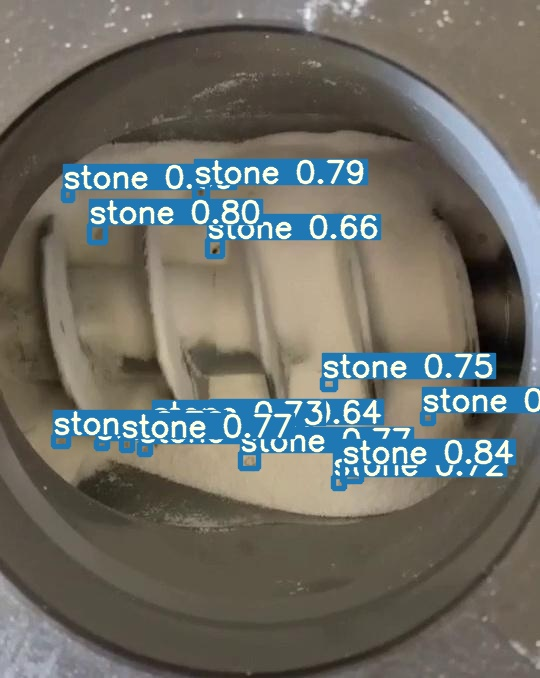

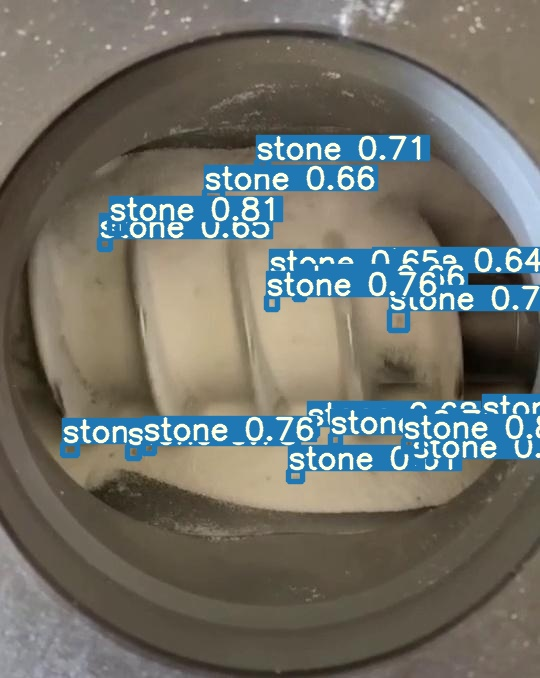

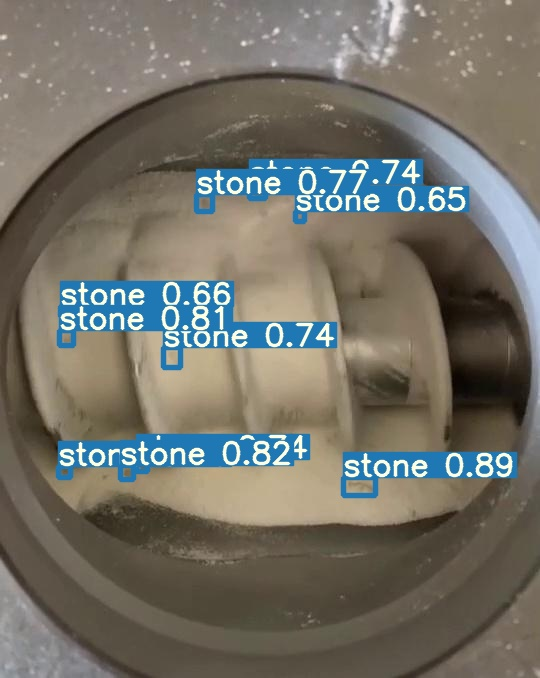

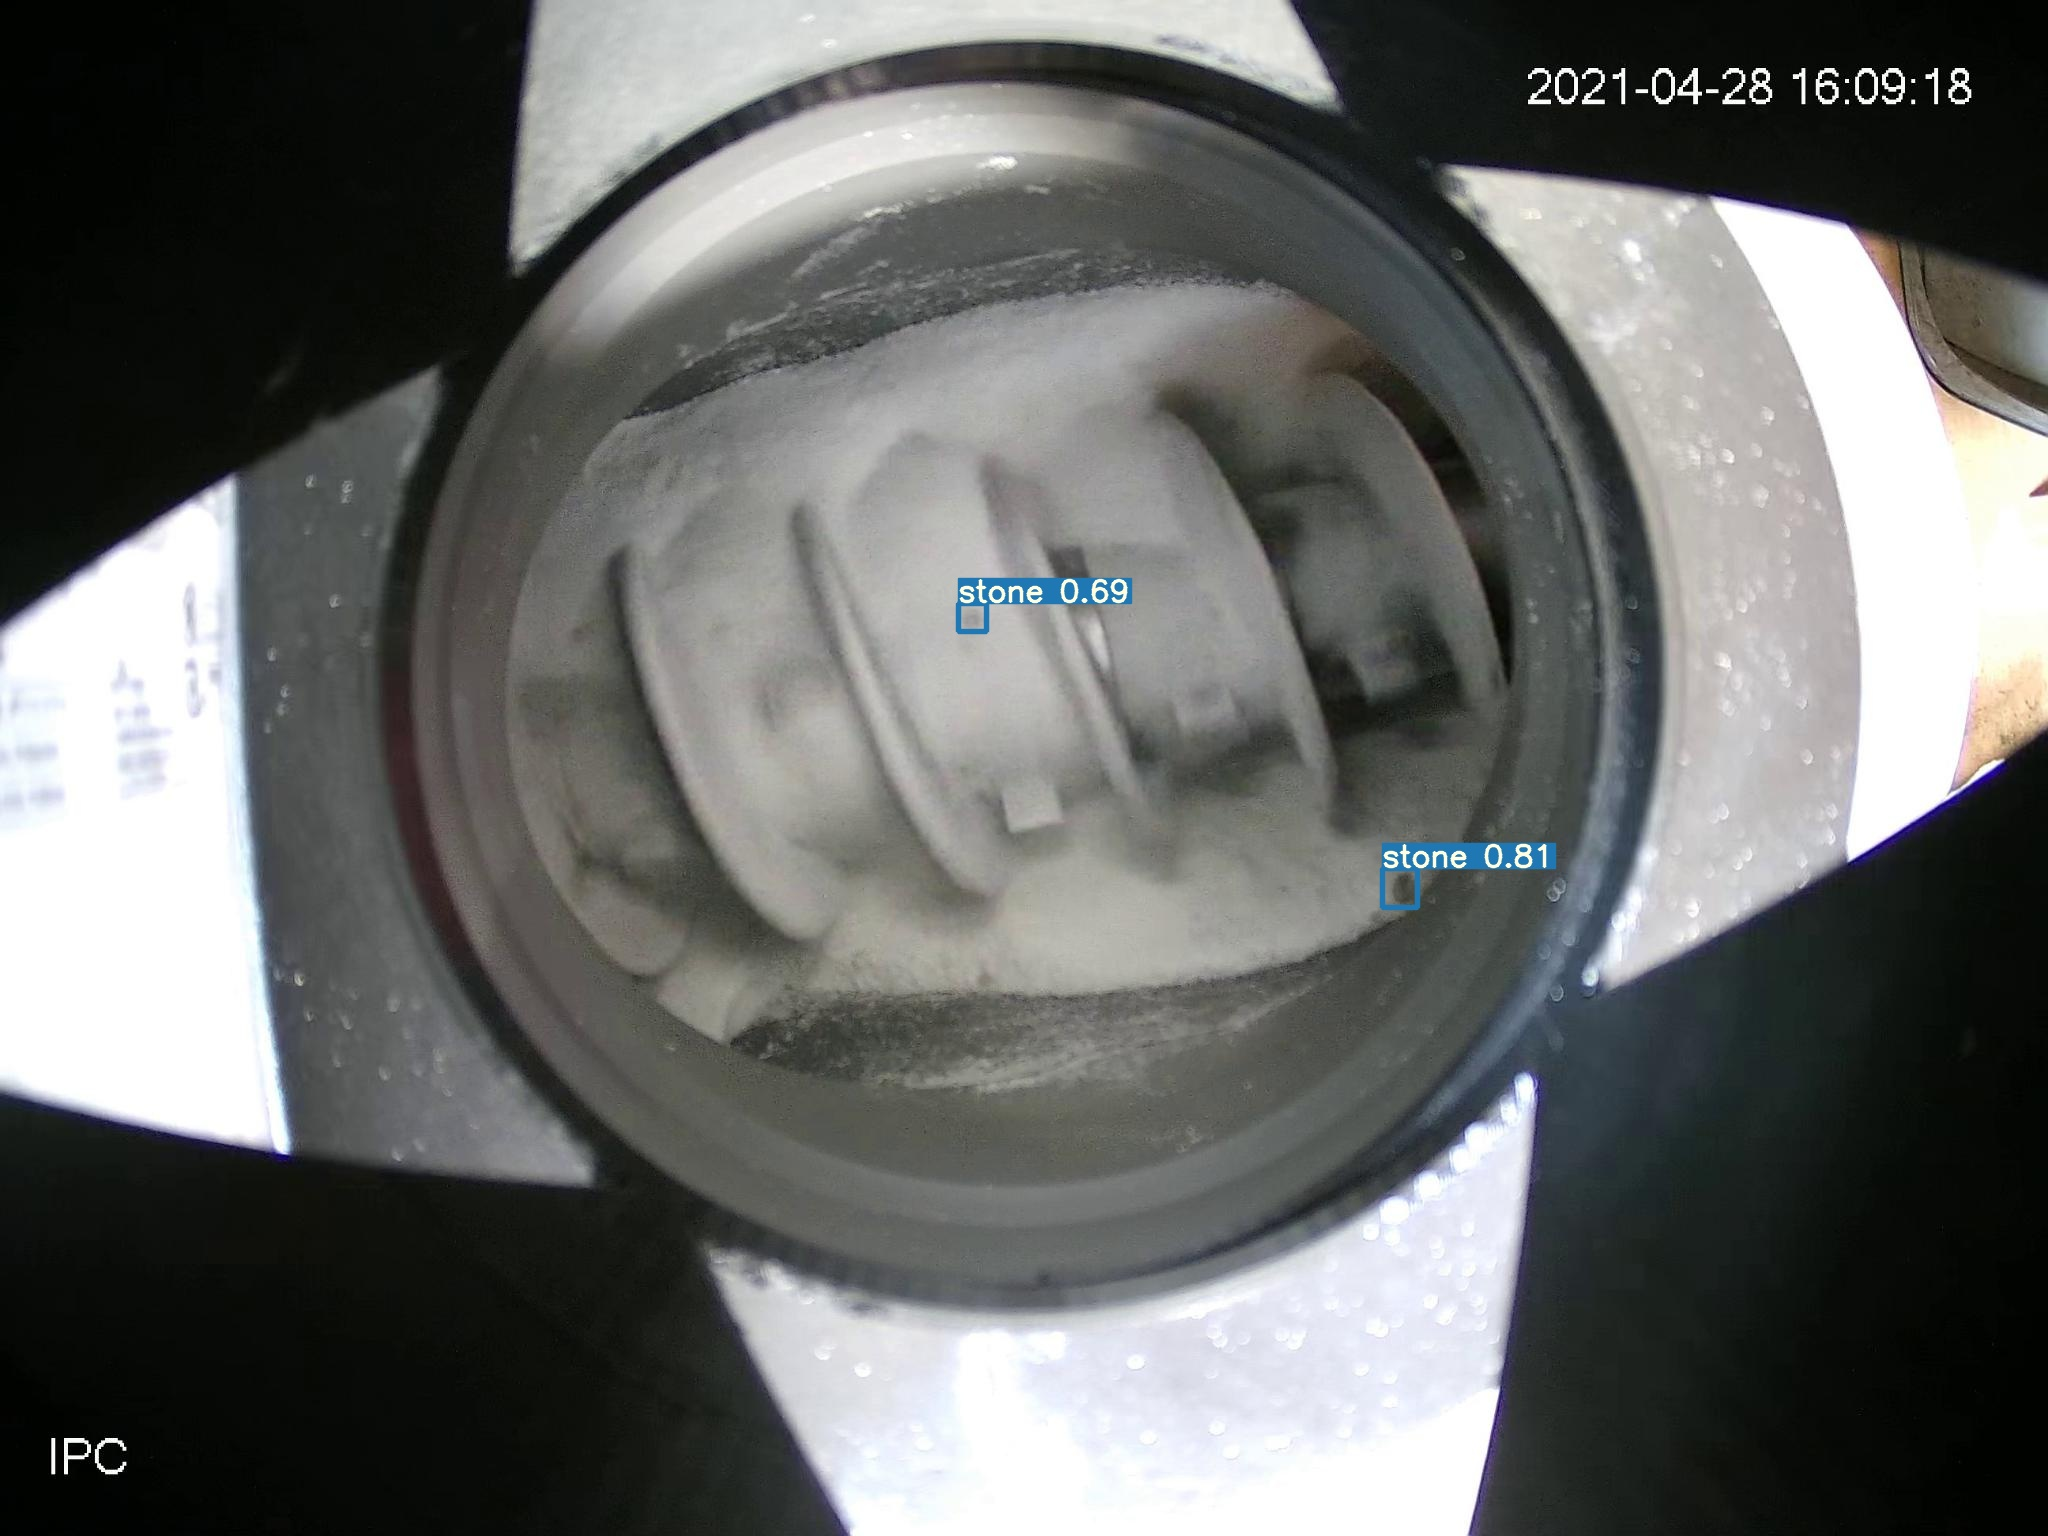

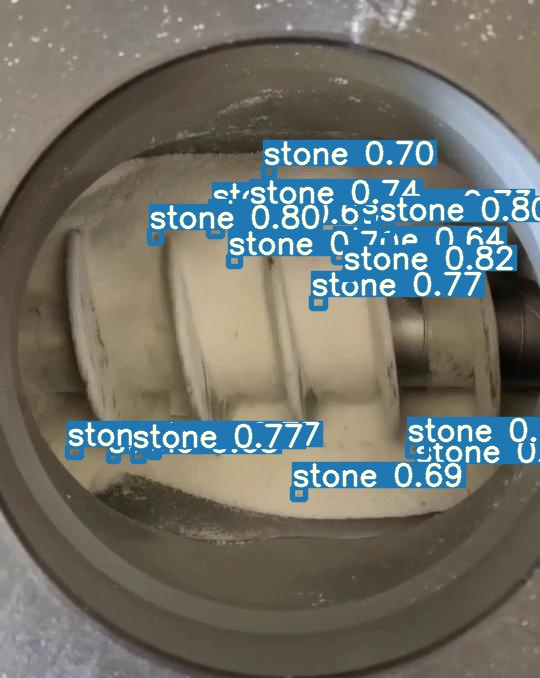

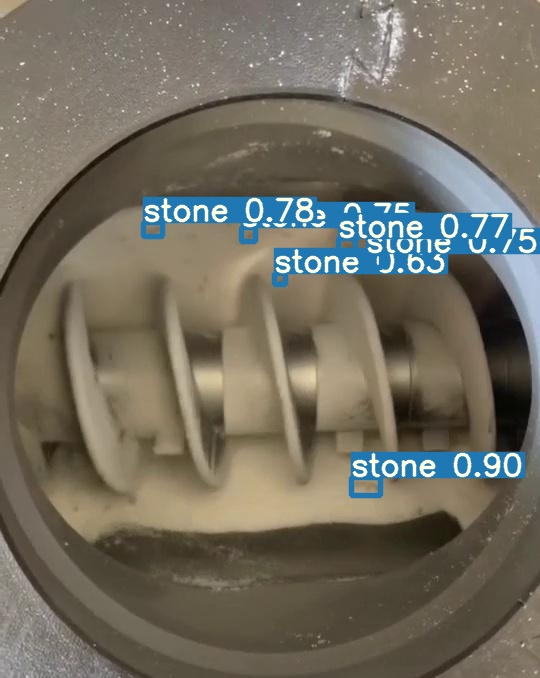

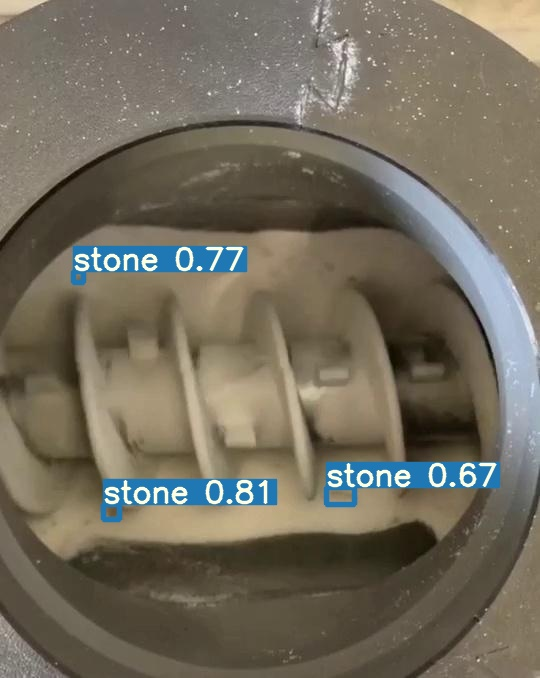

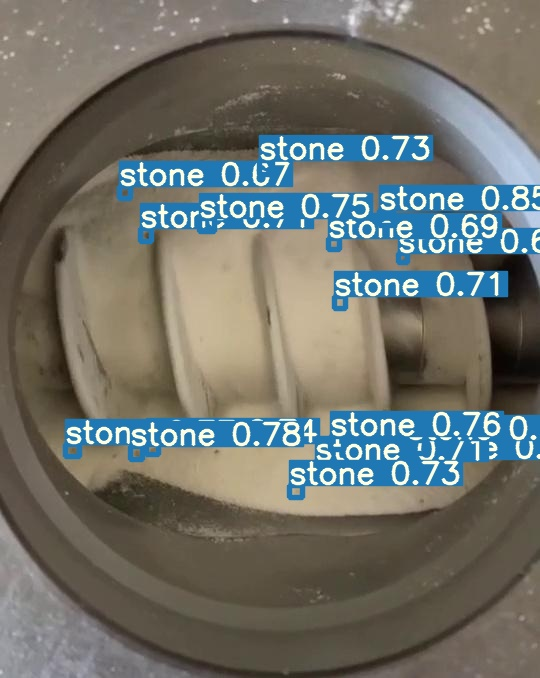

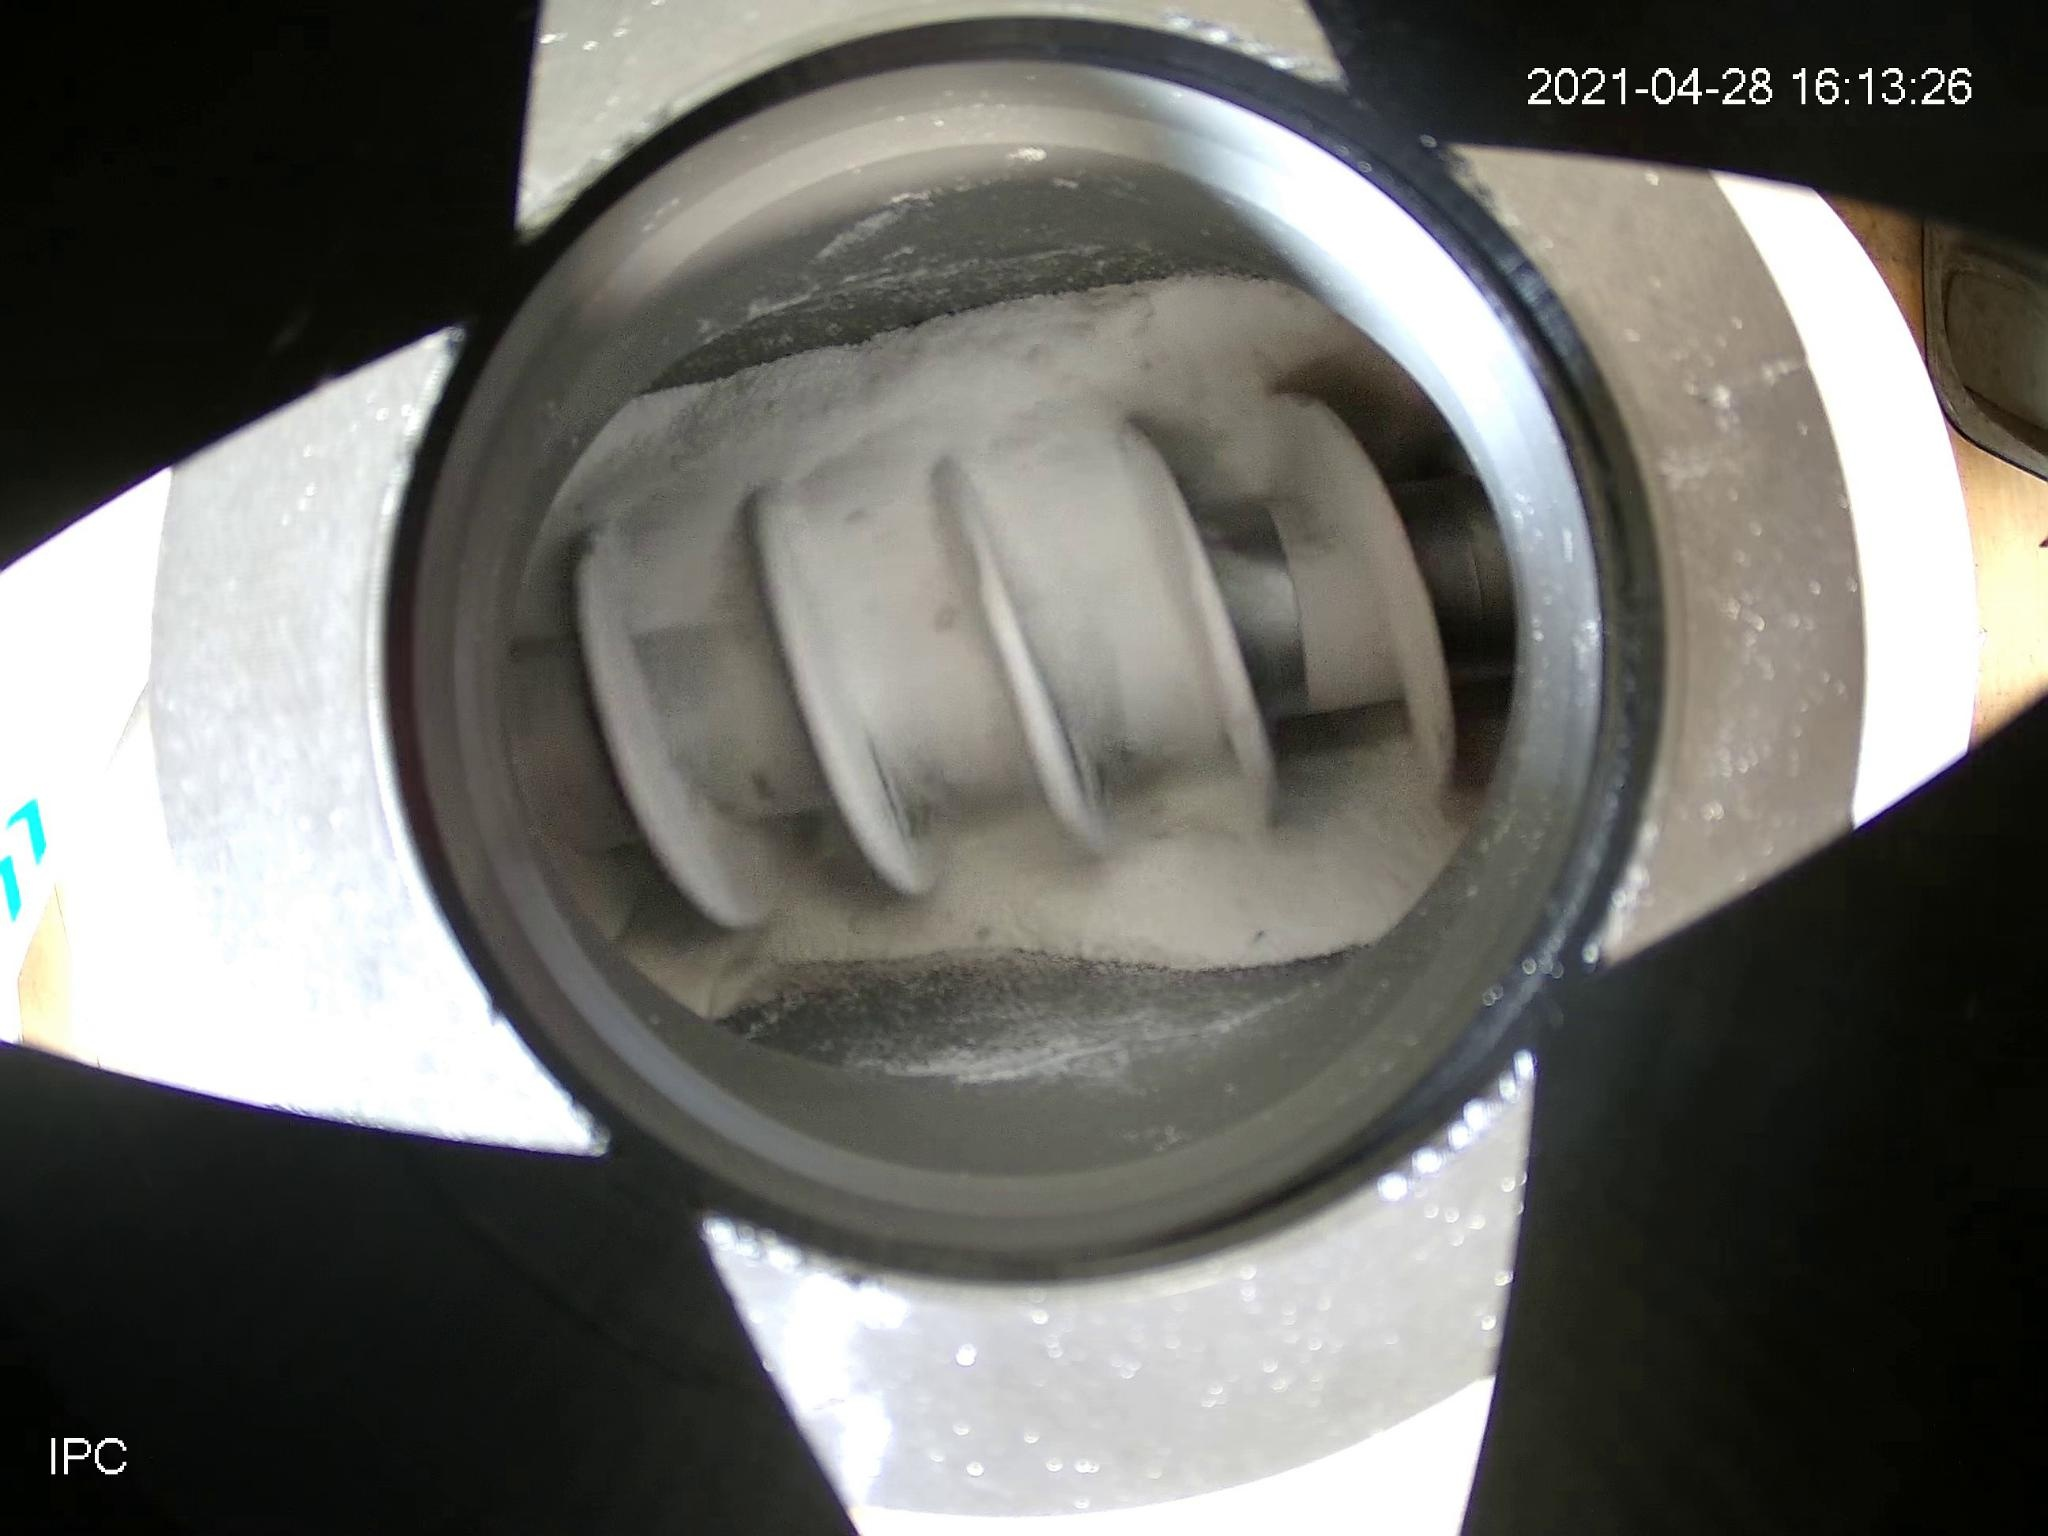

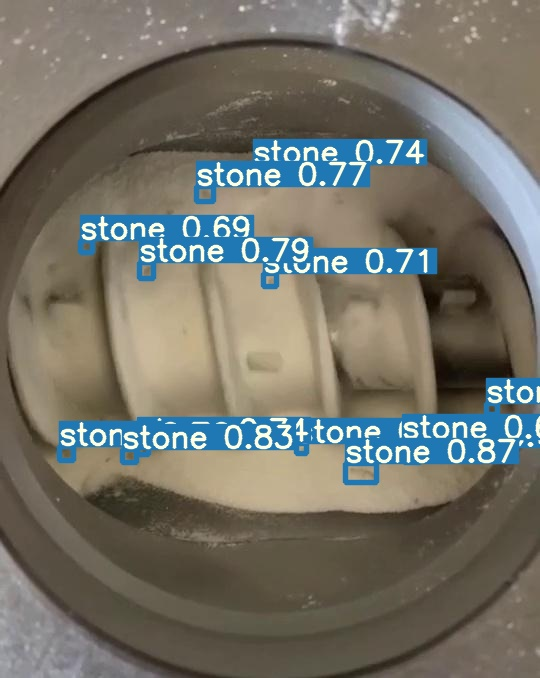

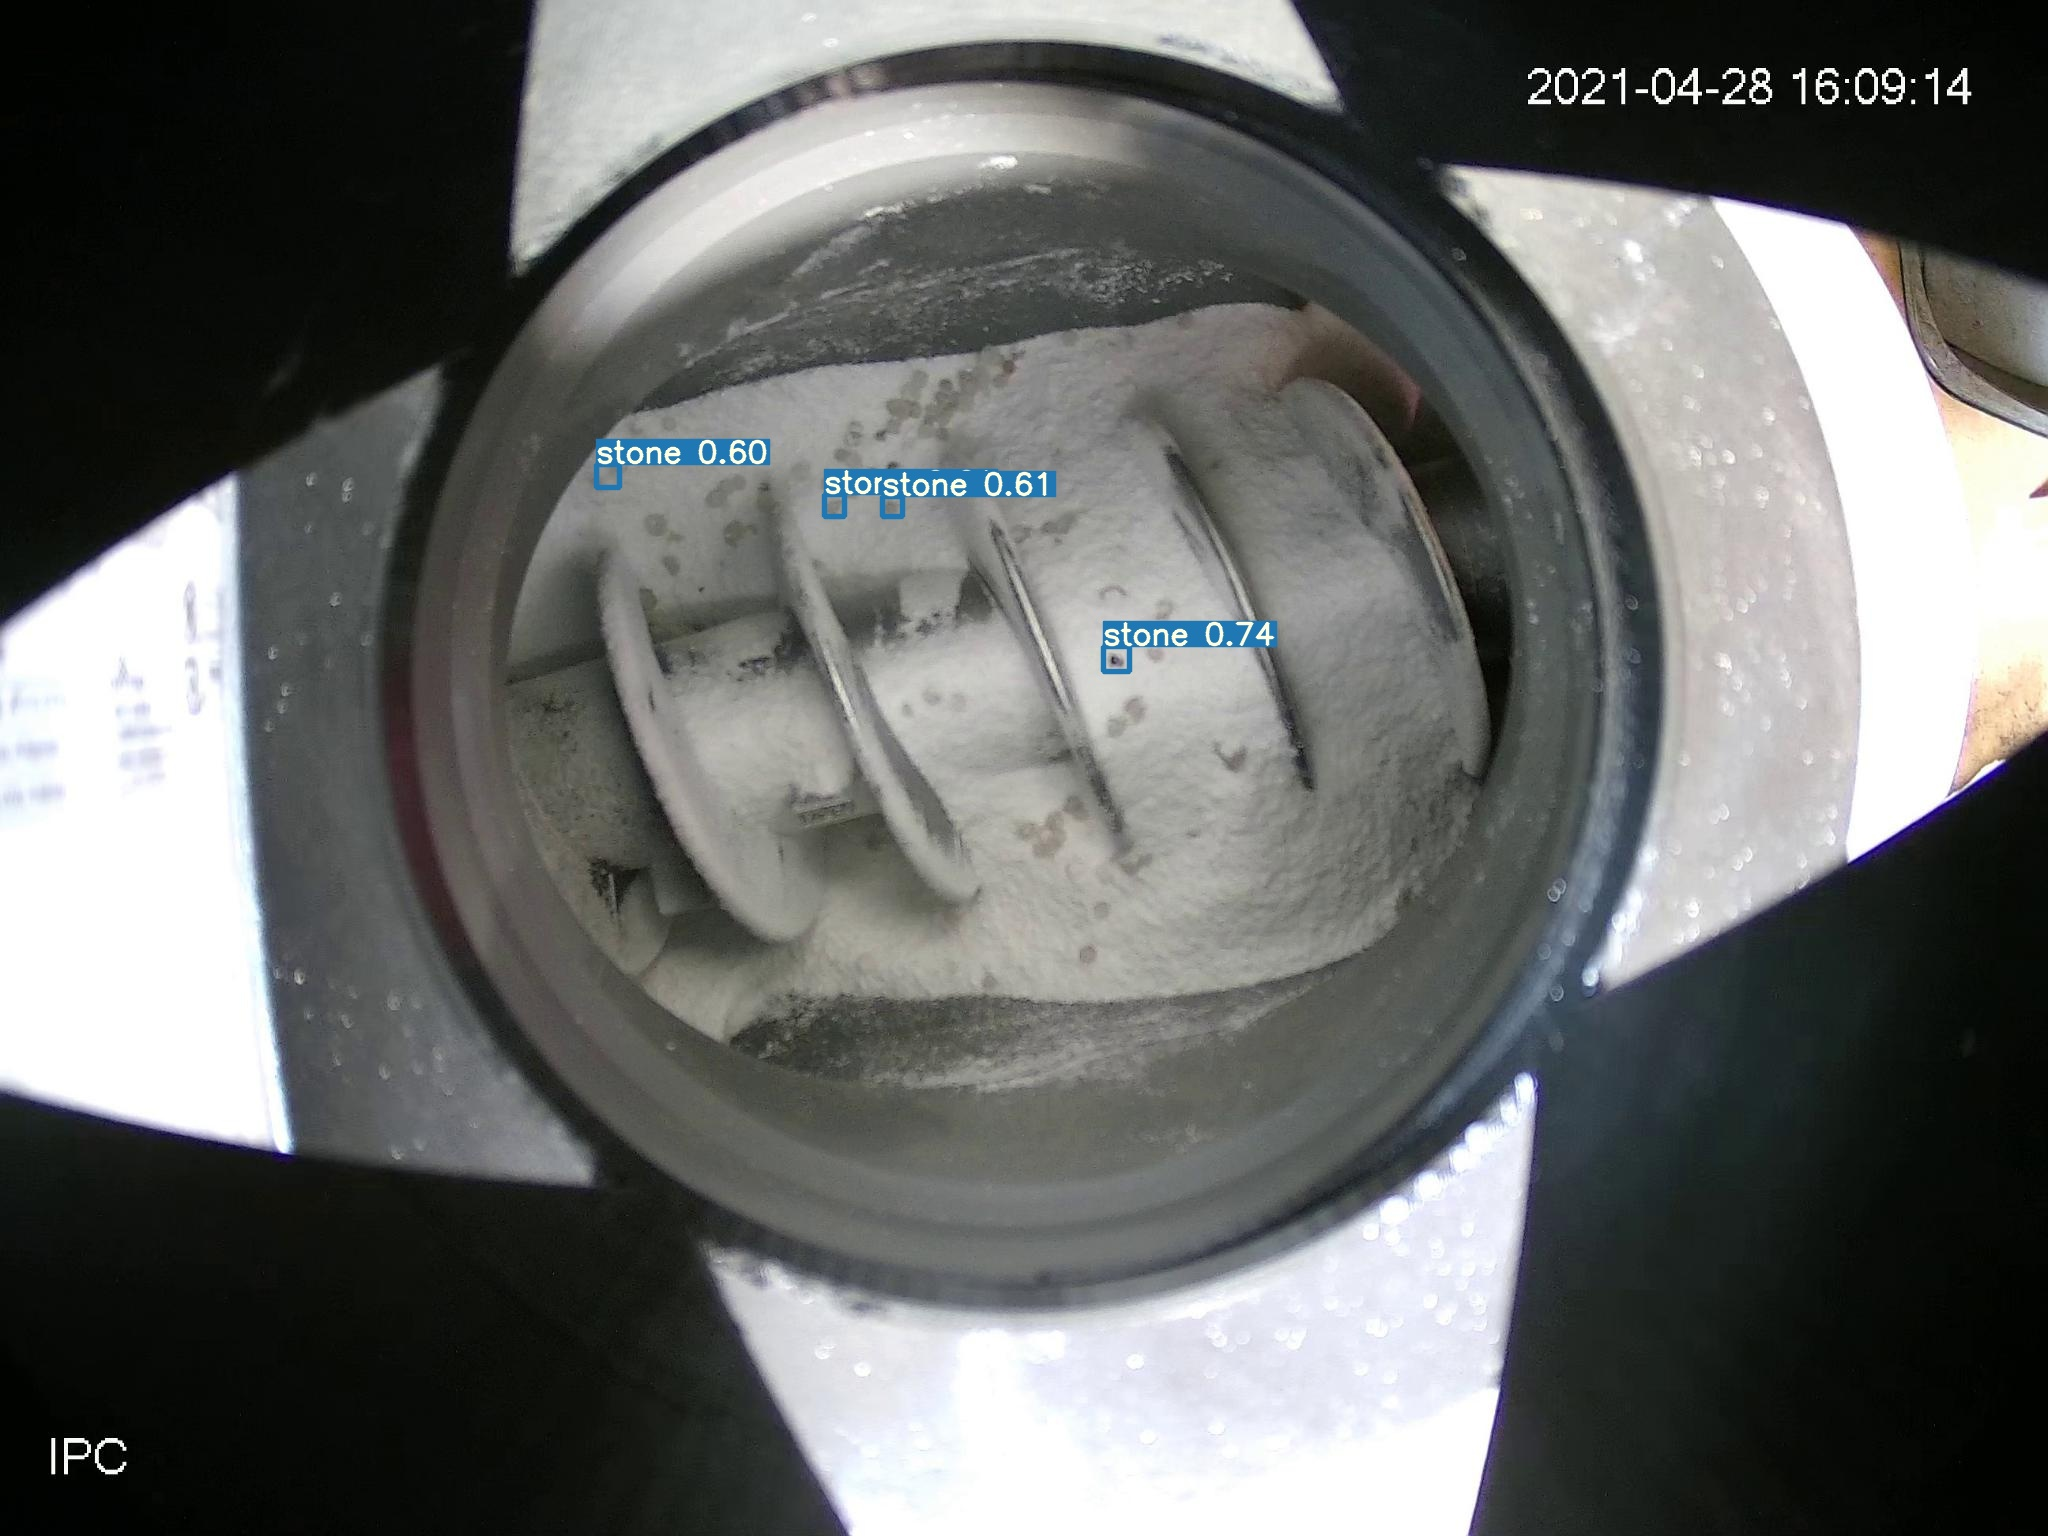

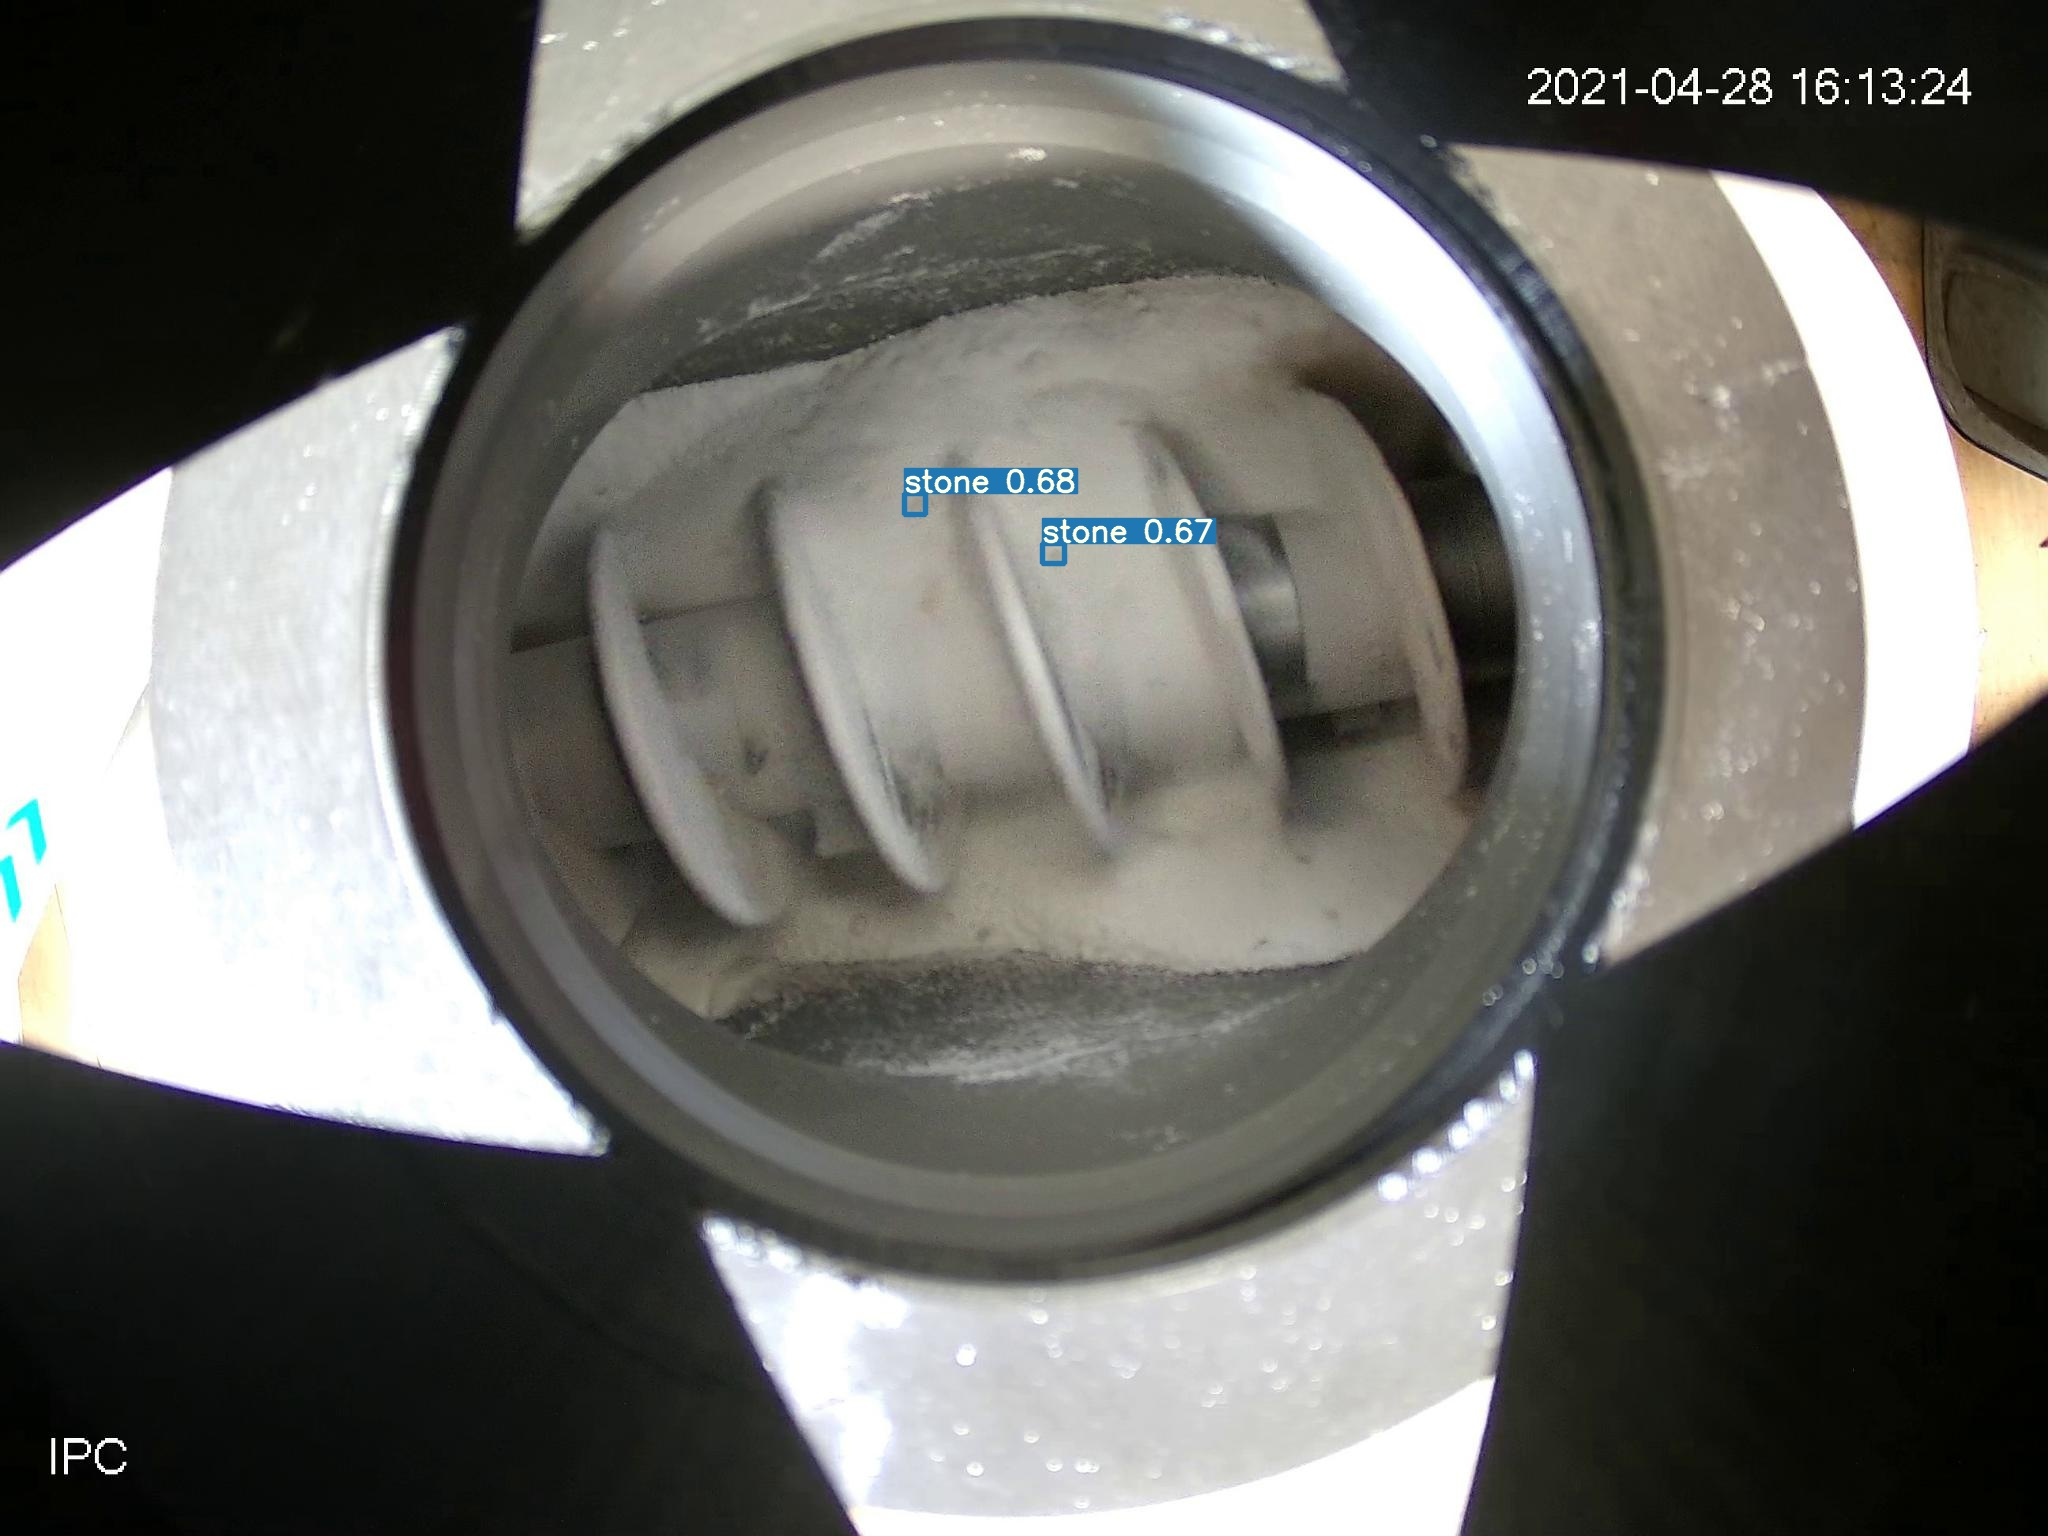

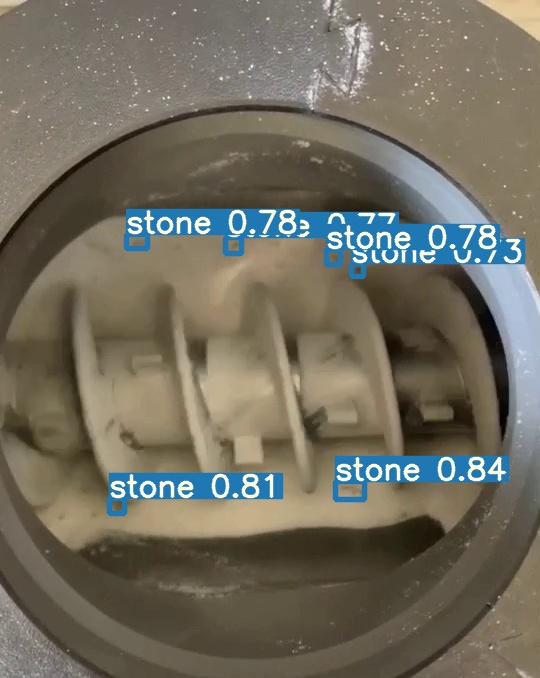

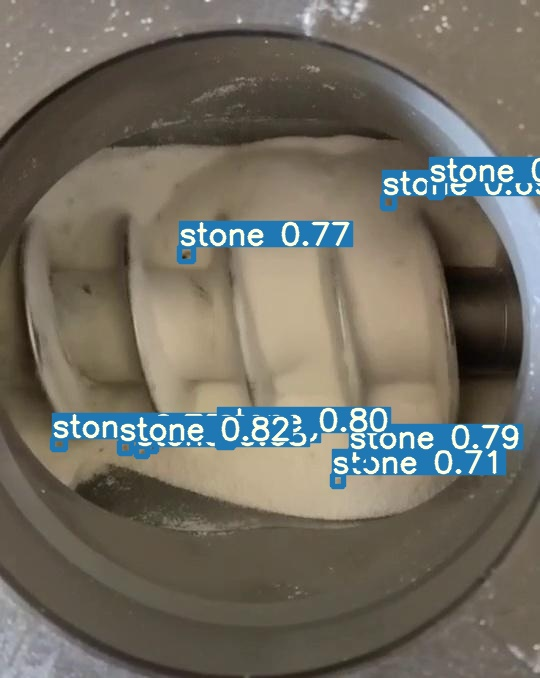

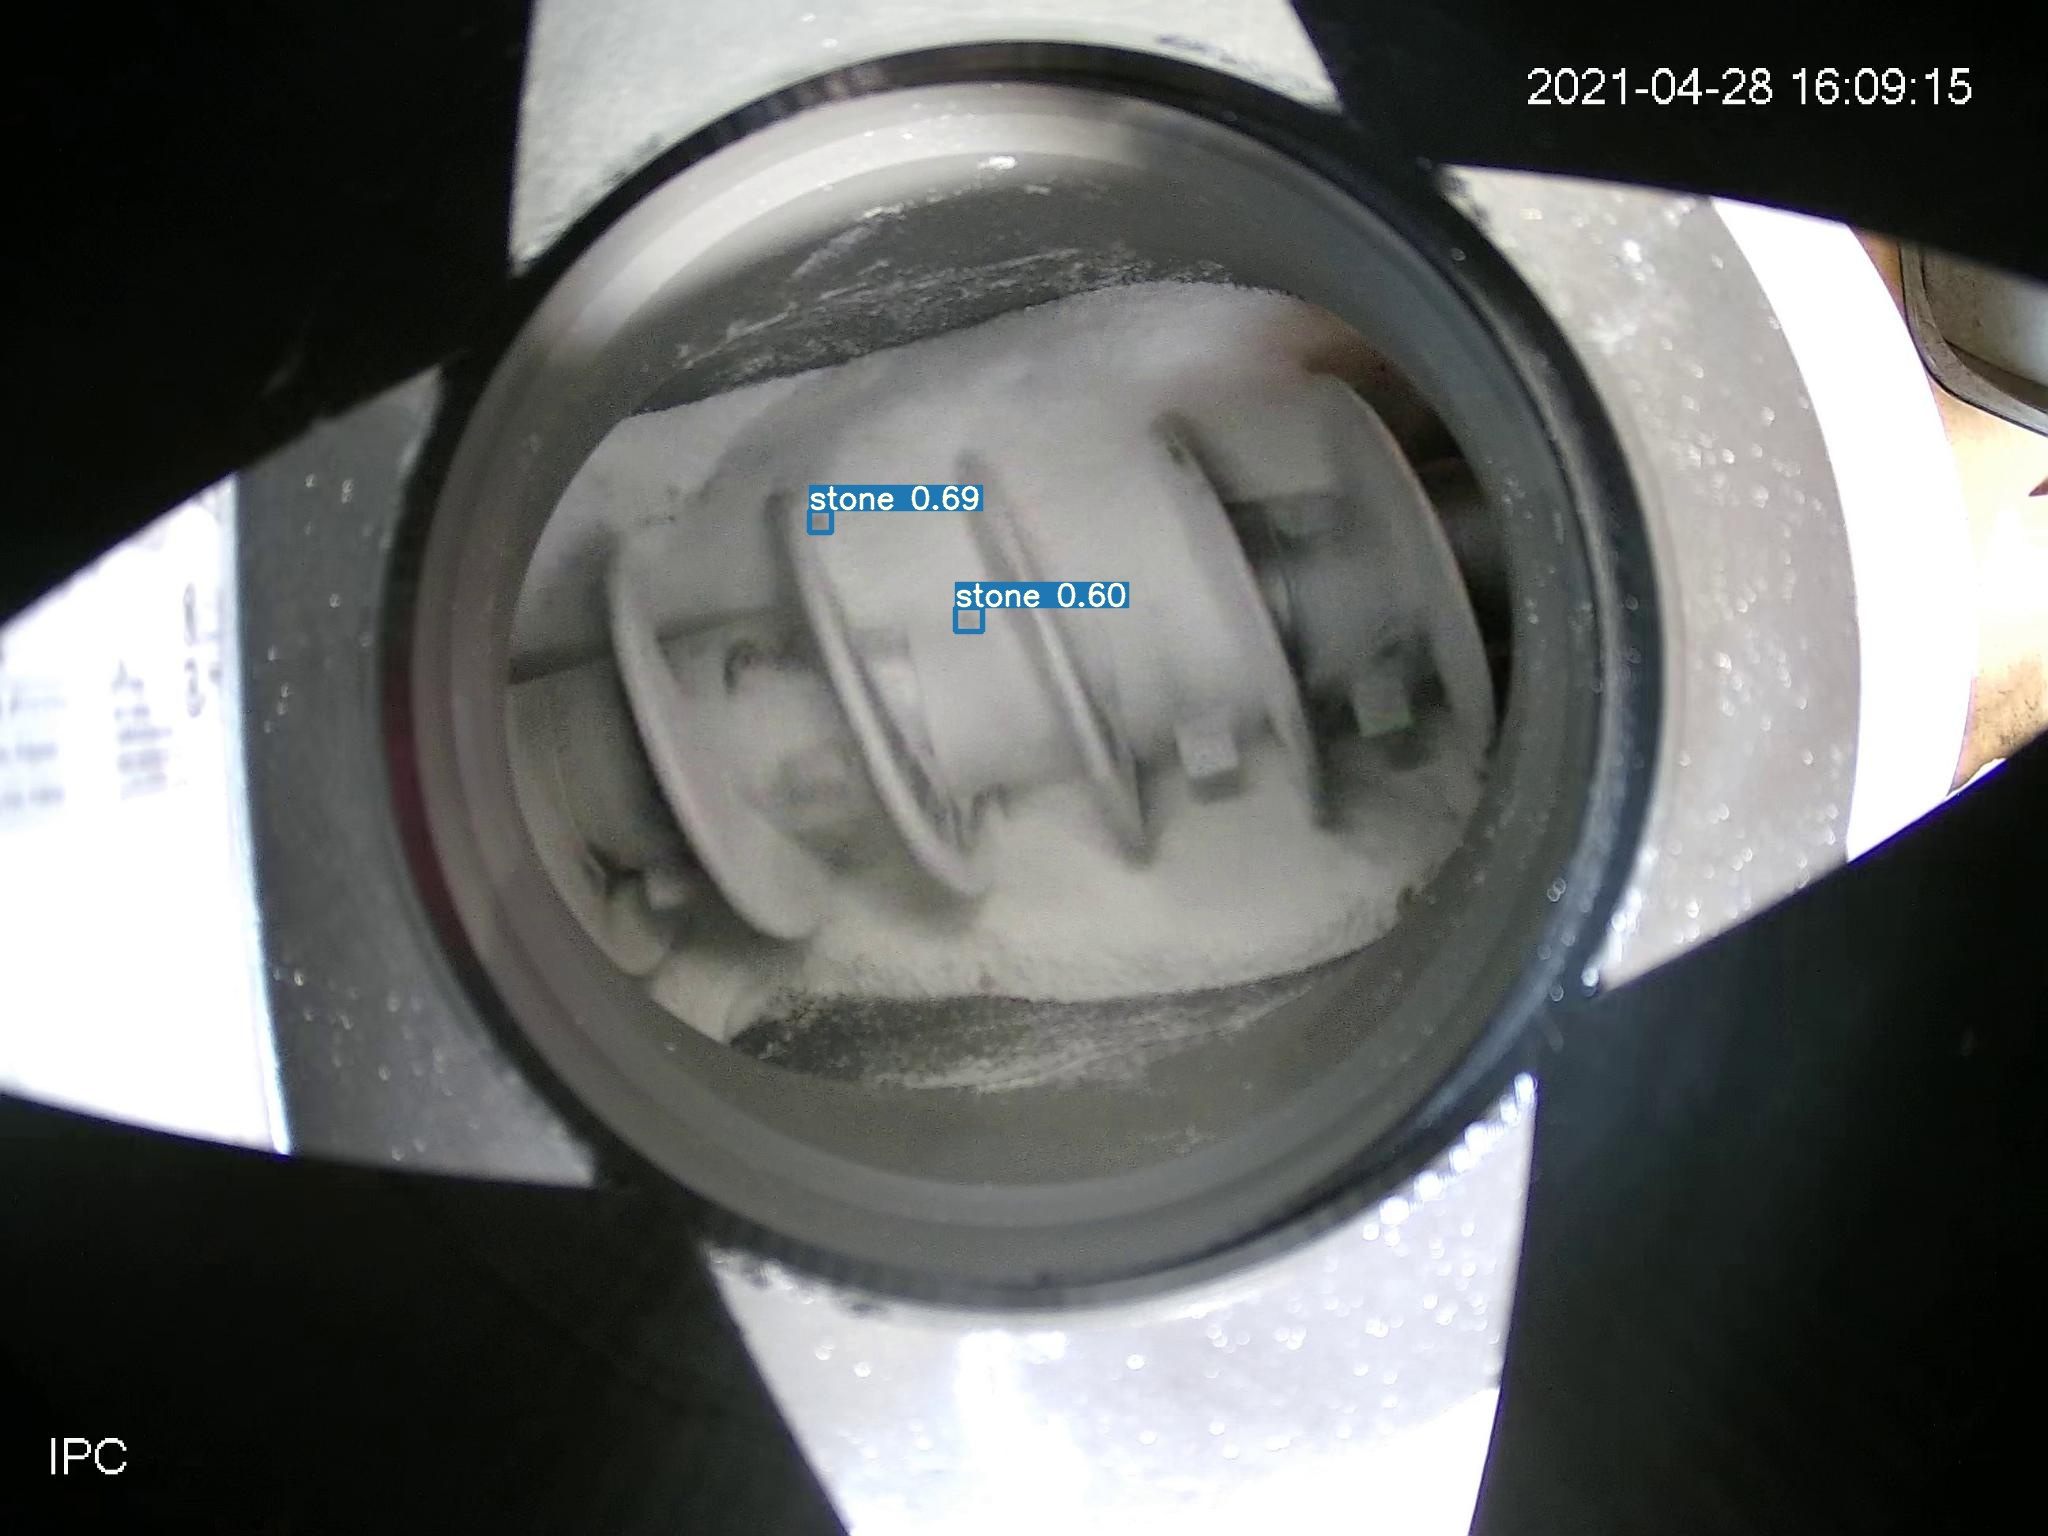

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# **Final:**
*Export and save your trained weights.*

In [ ]:
#Export Trained Weights for Future Inference
from google.colab import drive
#drive.mount('/content/gdrive')

%cp /content/yolov5/runs/train/yolov5_stone6/weights/last.pt /content/gdrive/My\ Drive